# Random Forest Model for Conflict Prediction - Impact of Drought Indicator

@author: Caroline Gasten

The present notebook has been run in kaggle. A random forest model for conflict prediction is built and consequently the role of drought indicators within the model is analysed.

## Settings

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#required packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, recall_score, make_scorer, precision_score, fbeta_score
import seaborn as sns
import pydot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import matplotlib as mpl
from cycler import cycler
from sklearn.inspection import permutation_importance #move up
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import datetime


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rf-dataframe-input-22062023ii/RF_dataframe_input.csv
/kaggle/input/rf-dataframe-input-04-06-2023/RF_dataframe_input.csv
/kaggle/input/rf-dataframe-input-22062023/RF_dataframe_input.csv
/kaggle/input/rf-dataframe-input-21062023/RF_dataframe_input.csv


In [2]:
#Figure style
tw_pt = 483.69
tw_inch = tw_pt/72.27
mpl.rc('figure', titlesize=11, labelsize=10, figsize=[tw_inch,tw_inch*(5**.5 - 1) / 2])#https://jwalton.info/Embed-Publication-Matplotlib-Latex/
mpl.rc('axes', titlesize=11, labelsize=10)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
colour_rng=['teal', 'salmon', 'lightblue', 'silver', 'darkseagreen', 'palevioletred', 'slategray']
mpl.rcParams['axes.prop_cycle'] = cycler(color=colour_rng)

## Preprocessing data

In [3]:
#upload the RF input dataframe to kaggle and read to current notebook
df = pd.read_csv('/kaggle/input/rf-dataframe-input-22062023ii/RF_dataframe_input.csv')

In [4]:
#percentage of months which are conflict months
print(f'The model is trained based on {len(df)} records with {(df.conflict_boolean==1).sum()/len(df)*100:.2f} % conflict months')

The model is trained based on 12744 records with 4.37 % conflict months


In [5]:
#input variables as categorical
df["spat_com_t-1"] = df["spat_com_t-1"].astype(int)
df["spat_oc_t-1"] = df["spat_oc_t-1"].astype(int)

In [6]:
#Spearman's rank correlation coefficient
df_inputfeatures =df.iloc[:,4:]
#code adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
corr = spearmanr(df_inputfeatures).correlation
pval = spearmanr(df_inputfeatures).pvalue

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)



Text(9.444444444444445, 0.5, 'input features')

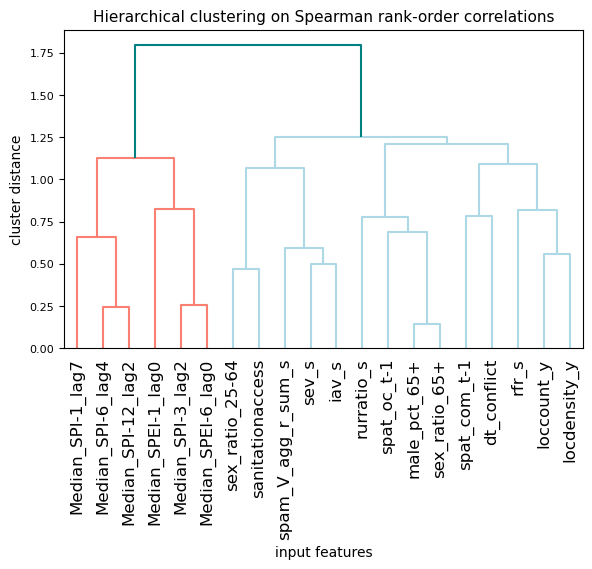

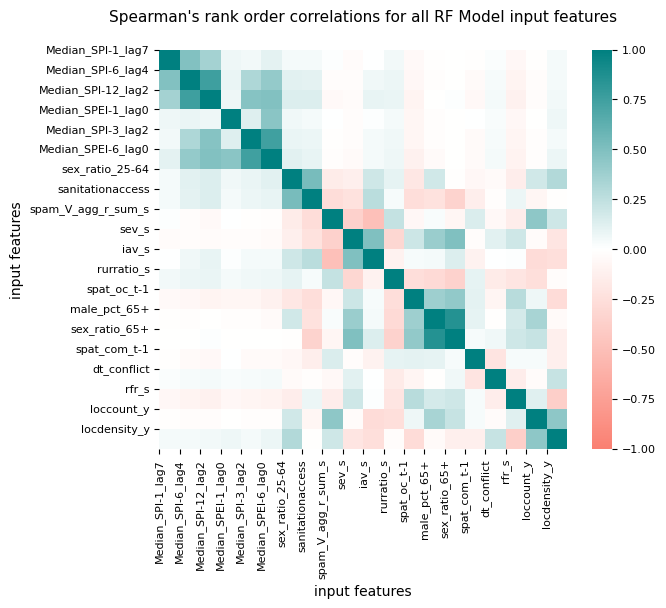

In [7]:
#Spearman's rank correlation coefficient - visualization
#code adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

#dendrogram of correlation clusters
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=df_inputfeatures.columns.tolist(), ax=None, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.title('Hierarchical clustering on Spearman rank-order correlations')
plt.xlabel('input features')
plt.ylabel('cluster distance')

plt.figure(figsize=[tw_inch,tw_inch*0.9])

#Spearman's rank correlation coefficient - matrix visualization
colors = [(250/255,128/255,114/255),(1,1,1), (0, 128/255, 128/255)]
cmap_name = 'salmon_to_teal'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sns.heatmap(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap=cmap, vmin=-1, vmax=1)
plt.xticks(dendro_idx,dendro["ivl"], rotation="vertical")
plt.yticks(dendro_idx, dendro["ivl"], rotation="horizontal")
plt.title("Spearman's rank order correlations for all RF Model input features", y=1.05)
plt.tight_layout()
plt.savefig('/kaggle/working/Spearmanrank.svg')
plt.xlabel('input features')
plt.ylabel('input features')

In [8]:
#retrieve all features with a cluster distance of 0.3 or higher
#code adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
cluster_ids = hierarchy.fcluster(dist_linkage, 0.3, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [9]:
#splitting training and testing dataset based on a temporal split
df_train = df[df.year <=2015]
X_train = df_train.iloc[:,np.array(selected_features) + 4]
Y_train = df_train['conflict_boolean']
date_train =[datetime.datetime(year, month, 1) for year, month in zip(df_train['year'], df_train['month'])]
df_test = df[df.year>2015]
X_test = df_test.iloc[:,np.array(selected_features) + 4]
Y_test = df_test['conflict_boolean']
date_test =[datetime.datetime(year, month, 1) for year, month in zip(df_test['year'], df_test['month'])]
X_names = list(X_train.columns)


In [10]:
#SMOTE-NC to oversample conflict events
sm = SMOTENC(categorical_features=[11,12], random_state=10)
X_train_os, Y_train_os = sm.fit_resample(X_train, Y_train)

## Hyperparameter tuning

In [11]:
#create pipeline to only use SMOTE-NC on training part of the data during cross-validation
#credits to https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['SMOTE-NC', SMOTENC(categorical_features=[11,12], random_state=10)],
                               ['classifier', RandomForestClassifier(random_state=10)]]) #, max_samples=0.7

In [12]:
#create cross-validation with 10 folds in a stratified way (=always the same percentage of conflict months)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

In [13]:
#performance metrics
recall_scorer = make_scorer(recall_score, pos_label=True)
precision_scorer = make_scorer(precision_score, pos_label=True)
f2_scorer = make_scorer(fbeta_score, pos_label=True, beta=2)

In [14]:
# set up Grid Search with cross-validation
params = {"classifier__n_estimators":[20, 30, 50, 100], "classifier__max_depth": [2,3, 5, 10], "classifier__max_features": [2, 3, 5, 7]} 

gs = GridSearchCV(estimator=pipeline, param_grid=params, scoring=recall_scorer, cv=stratified_kfold, n_jobs=-1)

In [15]:
#conduct Grid Search with cross-validation
import time

start=time.time()
gs.fit(X_train, Y_train)
end=time.time()
print(end-start)


344.02150416374207


In [16]:
print(f"best recall score: {gs.best_score_}")
print(f"corresponding parameters: {gs.best_params_}")

best recall score: 0.7707142857142857
corresponding parameters: {'classifier__max_depth': 2, 'classifier__max_features': 3, 'classifier__n_estimators': 20}


## Model training

In [17]:
#fit Random Forest Model with best parameters
rf = RandomForestClassifier(random_state=10, n_estimators=20, max_depth=2,max_features=3)
rf.fit(X_train_os, Y_train_os)

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=20,
                       random_state=10)

In [18]:
#predict conflict for testing dataset
Y_pred = rf.predict(X_test)
#classification report for testing dataset
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      4045
           1       0.12      0.75      0.21       203

    accuracy                           0.73      4248
   macro avg       0.55      0.74      0.52      4248
weighted avg       0.94      0.73      0.81      4248



In [19]:
#predict conflict for training dataset
Y_pred_train = rf.predict(X_train)
#classification report for training dataset
print(classification_report(Y_train, Y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8142
           1       0.12      0.79      0.20       354

    accuracy                           0.74      8496
   macro avg       0.55      0.76      0.53      8496
weighted avg       0.95      0.74      0.82      8496



In [20]:
#recall if True defined as positive
recall_score(Y_test, Y_pred, pos_label=True, average='binary')

0.7487684729064039

In [21]:
#F2 score
f2_scorer(rf, X_test, Y_test)

0.36911121903836813

## Visualization

In [22]:
#exemplary visualization of a tree diagram
#credits to https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
tree = rf.estimators_[1]
export_graphviz(tree, out_file='tree.dot', feature_names = X_names, rounded=True, precision=0)
(graph, )= pydot.graph_from_dot_file('tree.dot')
graph.write_png('/kaggle/working/tree.png')

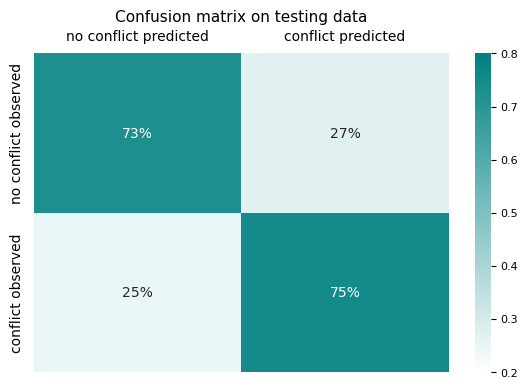

In [23]:
# Confusion matrix
colors = [(1, 1, 1), (0, 0.5, 0.5)]
cmap_name = 'white_to_teal'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)



conf_mat = confusion_matrix(Y_test, Y_pred, normalize='true')
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt='.0%', cmap=cmap, vmin=0.2, vmax=0.8)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)
plt.xticks(ticks=[0.5,1.5], labels=['no conflict predicted', 'conflict predicted'])
plt.yticks(ticks=[0.5, 1.5], labels=['no conflict observed', 'conflict observed'])
plt.title("Confusion matrix on testing data")
#plt.xlabel("predicted")
#plt.ylabel("observed")
#plt.label_params()
plt.savefig('/kaggle/working/conf_mat.svg')

## Feature importance

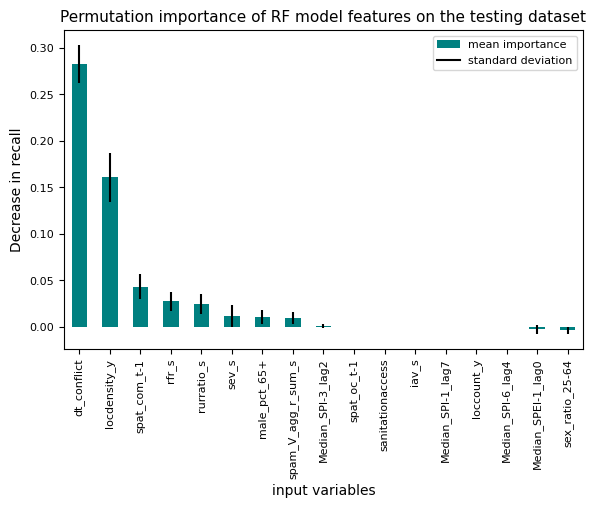

In [24]:
#Permutation feature importance (PFI) on testing dataset
scoring={'recall':recall_scorer}

#compute PFI on testing dataset
pi = permutation_importance(rf, X_test, Y_test, n_repeats=30, random_state=10, scoring=scoring)

#plot of PFI on testing dataset
for metric in pi:
    fig, ax = plt.subplots()
    score = pi[metric]
    importances = pd.DataFrame(data={"mean_importance": score.importances_mean, "importance_std": score.importances_std}, index=X_names)
    importances.sort_values(axis=0, by="mean_importance", ascending=False, inplace=True)
    importances.mean_importance.plot.bar(yerr=importances.importance_std, label="mean importance")
plt.title("Permutation importance of RF model features on the testing dataset")
handles, labels = ax.get_legend_handles_labels()
std_line = Line2D([0], [0], color='k', label='standard deviation')
handles.append(std_line)
plt.legend(handles=handles)
plt.xlabel('input variables')
plt.ylabel('Decrease in recall')
plt.savefig('/kaggle/working/PermImportanceTesting.svg')

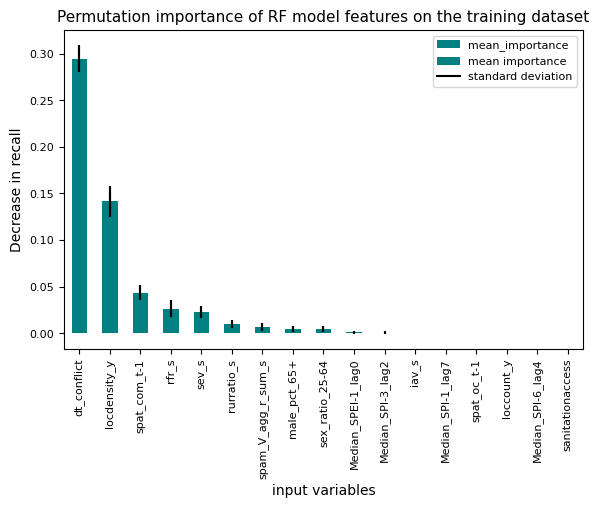

In [25]:
#PFI on training dataset
scoring={'recall':recall_scorer} #score used to evaluate permutation feature importance

#compute PFI on training dataset
pi = permutation_importance(rf, X_train, Y_train, n_repeats=30, random_state=10, scoring=scoring)

#plot of PFI on training dataset
for metric in pi:
    fig, ax = plt.subplots()
    score = pi[metric]
    importances = pd.DataFrame(data={"mean_importance": score.importances_mean, "importance_std": score.importances_std}, index=X_names)
    importances.sort_values(axis=0, by="mean_importance", ascending=False, inplace=True)
    importances.mean_importance.plot.bar(yerr=importances.importance_std)
    importances.mean_importance.plot.bar(yerr=importances.importance_std, label="mean importance")
plt.title("Permutation importance of RF model features on the training dataset")
handles, labels = ax.get_legend_handles_labels()
std_line = Line2D([0], [0], color='k', label='standard deviation')
handles.append(std_line)
plt.legend(handles=handles)
plt.xlabel('input variables')
plt.ylabel('Decrease in recall')
plt.savefig('/kaggle/working/PermImportanceTraining.svg')

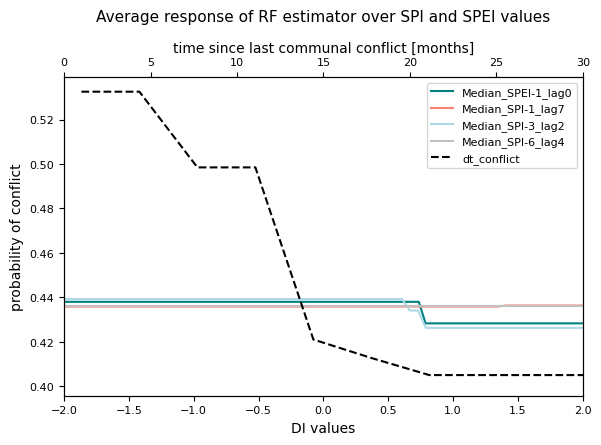

In [26]:
#Partial Dependence Plot of drought indicators compared to most-explaining variable
fig=plt.figure()
ax1=fig.add_subplot(111)
ax2 =ax1.twiny()
feature_names = X_names[0:4]
for f in [0,1,2,3]:
    p_dep = partial_dependence(rf, X_test, features=[f], categorical_features=[11,12], percentiles=[0,1])
    ax1.plot(p_dep['values'][0], p_dep['average'][0], label=feature_names[f])
ax1.set_xlim(-2,2)
handles,labels=ax1.get_legend_handles_labels()
p_dep = partial_dependence(rf, X_test, features=[13], categorical_features=[11,12], percentiles=[0,1])
cdt = ax2.plot(p_dep['values'][0], p_dep['average'][0], ls='--', color='k', label='dt_conflict')
handles.append(cdt[0])
ax2.set_xlim(0,30)
plt.legend(handles=handles)
ax1.set_xlabel('DI values')
ax2.set_xlabel('time since last communal conflict [months]')
ax1.set_ylabel('probability of conflict')
plt.title('Average response of RF estimator over SPI and SPEI values', y=1.15);
#PartialDependenceDisplay.from_estimator(rf, X_test, features=[0,1,2,3,13], n_cols=3, categorical_features=[11,12], kind='average', ax=ax)
plt.savefig('/kaggle/working/average_effects_wholeRF.svg')

## Analysis for North-Western Kenya

In [27]:
#KEN.43 - Turkana
X_test_TU = X_test[df_test.GID_1=='KEN.43']
Y_test_TU = Y_test[df_test.GID_1=='KEN.43']
Y_pred_TU = rf.predict(X_test_TU)
#KEN.47 - West Pokot
X_test_WP = X_test[df_test.GID_1=='KEN.47']
Y_test_WP = Y_test[df_test.GID_1=='KEN.47']
Y_pred_WP = rf.predict(X_test_WP)
#KEN.25 - Marsabit
X_test_MA = X_test[df_test.GID_1=='KEN.25']
Y_test_MA = Y_test[df_test.GID_1=='KEN.25']
Y_pred_MA = rf.predict(X_test_MA)

In [28]:
def mean_part_dep(rf, X_test, feature):
    p_dep = partial_dependence(rf, X_test, features=[feature], categorical_features=[11,12], percentiles=[0,1])
    p_dep_mean = p_dep['average'][0]
    p_dep_vals = p_dep['values'][0]
    return p_dep_mean, p_dep_vals


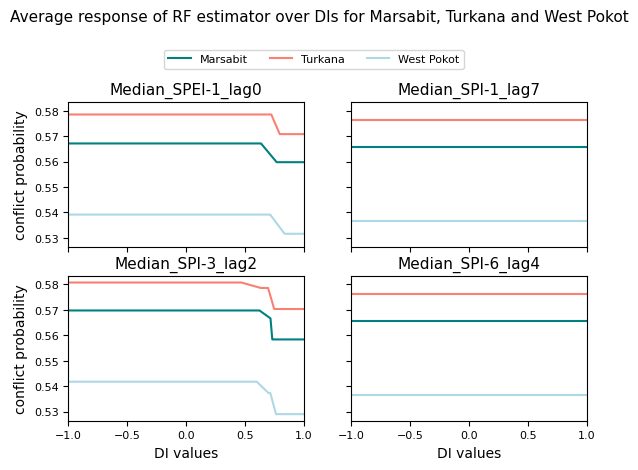

In [29]:

fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
for i in range(4):
    feature = i
    ax = axs.flatten()[i]
    
    p_dep_MA, DI_vals_MA = mean_part_dep(rf, X_test_MA, feature)
    ax.plot(DI_vals_MA, p_dep_MA, label='Marsabit')
    p_dep_TU, DI_vals_TU = mean_part_dep(rf, X_test_TU, feature)
    ax.plot(DI_vals_TU, p_dep_TU, label='Turkana')
    p_dep_WP, DI_vals_WP = mean_part_dep(rf, X_test_WP, feature)
    ax.plot(DI_vals_WP, p_dep_WP, label='West Pokot')
    
    if i in [2,3]:
        ax.set_xlabel('DI values')
    if i in [0,2]:
        ax.set_ylabel('conflict probability')
    
    ax.set_title(X_test_TU.columns[feature])
plt.xlim(-1,1)
plt.suptitle('Average response of RF estimator over DIs for Marsabit, Turkana and West Pokot', y=1.105)
plt.legend(bbox_to_anchor=[0.5,2.6], ncols=3)

#plt.tight_layout()

plt.savefig('/kaggle/working/average_effects_RF_counties.svg')

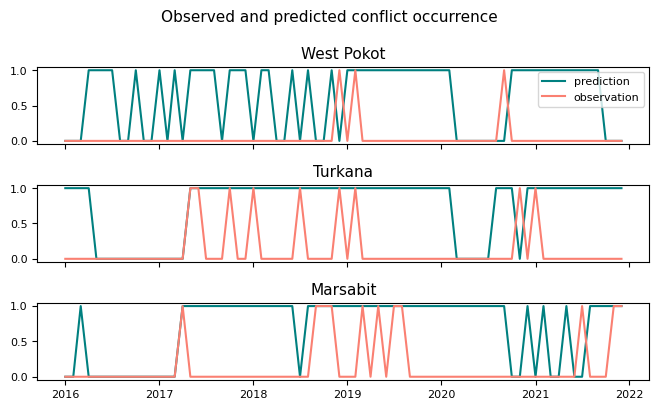

In [30]:
#plot of predicted vs. observed conflict occurrence in the three counties
fig, axs = plt.subplots(3,1, sharex=True)
axs[0].plot(np.unique(date_test),Y_pred_WP, label='prediction')
axs[0].plot(np.unique(date_test),Y_test_WP, label='observation')
axs[0].set_title('West Pokot')
axs[1].plot(np.unique(date_test),Y_pred_TU)
axs[1].plot(np.unique(date_test),Y_test_TU)
axs[1].set_title('Turkana')
axs[2].plot(np.unique(date_test),Y_pred_MA)
axs[2].plot(np.unique(date_test),Y_test_MA)
axs[2].set_title('Marsabit')
plt.suptitle('Observed and predicted conflict occurrence')
plt.tight_layout()
axs[0].legend()
plt.savefig('/kaggle/working/conflictpred.svg')